In [ ]:
# -*- coding: utf-8 -*-
'''ResNet50 model for Keras.
# Reference:
- [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)
Adapted from code contributed by BigMoyan.
'''
from __future__ import print_function

import numpy as np
import warnings
import tensorflow

%env KERAS_BACKEND=tensorflow
from keras.callbacks import LearningRateScheduler
import keras
from keras.layers import Input
from keras import layers
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import ZeroPadding2D
from keras.layers import AveragePooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import BatchNormalization
from keras.models import Model
from keras.preprocessing import image
import keras.backend as K
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.imagenet_utils import _obtain_input_shape
from keras.engine.topology import get_source_inputs

def identity_block_preactive(input_tensor, kernel_size, filters, stage, block):

    filters1, filters2, filters3 = filters
    
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
  
    x = BatchNormalization(axis=bn_axis)(input_tensor)
    x = Activation('relu')(x)
    x = Conv2D(filters1, (3, 3),
               kernel_initializer="he_normal",
               kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization(axis=bn_axis)(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, (3,3),
               padding='same',
               kernel_initializer="he_normal",
               kernel_regularizer=l2(0.0001))(x)

    x = layers.add([x, input_tensor])

    return x

def conv_block_preactive(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):

    filters1, filters2, filters3 = filters
    
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
        
    x = Conv2D(filters1, (3, 3), strides=strides,
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001))(input_tensor)
    x = BatchNormalization(axis=bn_axis)(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, (3,3), padding='same',
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001))(x)


    shortcut = Conv2D(filters3, (1, 1), strides=strides,
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001))(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis)(shortcut)

    x = layers.add([x, shortcut])
    return x


def identity_block_bottleneck(input_tensor, kernel_size, filters, stage, block):

    filters1, filters2, filters3 = filters
    
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
  

    x = Conv2D(filters1, (1, 1),
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001))(input_tensor)
    x = BatchNormalization(axis=bn_axis)(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size,
               padding='same',
               kernel_initializer="he_normal",
               kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization(axis=bn_axis)(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1),
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization(axis=bn_axis)(x)

    x = layers.add([x, input_tensor])
    x = Activation('relu')(x)
    return x


def conv_block_bottleneck(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):

    filters1, filters2, filters3 = filters
    
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
        
    x = Conv2D(filters1, (1, 1), strides=strides,
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001))(input_tensor)
    x = BatchNormalization(axis=bn_axis)(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same',
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization(axis=bn_axis)(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1))(x)
    x = BatchNormalization(axis=bn_axis)(x)

    shortcut = Conv2D(filters3, (1, 1), strides=strides,
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001))(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis)(shortcut)

    x = layers.add([x, shortcut])
    x = Activation('relu')(x)
    return x


def ResNet50_cifar_small(input_tensor=None, input_shape=None,
             pooling=None,
             classes=1000):

    # Determine proper input shape
    input_shape = (32,32,3)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1

    x = ZeroPadding2D((1, 1))(img_input)
    x = Conv2D(16, (3, 3), strides=(2, 2), name='conv1')(x)
    x = BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = Activation('relu')(x)
    
    block_shape = K.int_shape(x)
    print(block_shape)
    
    x = conv_block(x, 3, [16, 16, 64], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [16, 16, 64], stage=2, block='b')
    x = identity_block(x, 3, [16, 16, 64], stage=2, block='c')
    
    block_shape = K.int_shape(x)
    print(block_shape)
    
    x = conv_block(x, 3, [32, 32, 128], stage=3, block='a')
    x = identity_block(x, 3, [32, 32, 128], stage=3, block='b')
    x = identity_block(x, 3, [32, 32, 128], stage=3, block='c')
    
    block_shape = K.int_shape(x)
    print(block_shape)
    
    x = conv_block(x, 3, [64, 64, 256], stage=4, block='a')
    x = identity_block(x, 3, [64, 64, 256], stage=4, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=4, block='c')
    
    
    block_shape = K.int_shape(x)
    print(block_shape)

    x = AveragePooling2D(pool_size=(block_shape[1], block_shape[2]),strides=(1, 1))(x)

   
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(classes, activation='softmax', name='fc1000')(x)


    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='resnet50')

    return model



   

In [77]:
from keras.datasets import cifar10


(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
mean_image = np.mean(x_train, axis=0)
x_train -= mean_image
x_test -= mean_image
x_train = x_train/128
x_test = x_test/128 
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [ ]:
from keras.callbacks import ReduceLROnPlateau, CSVLogger, EarlyStopping
from keras.regularizers import l2

batch_size = 128
nb_classes = 10
nb_epoch = 200
data_augmentation = True
lr_schedule = [40,60,70] # epoch_step
def schedule(epoch_idx):
    if (epoch_idx + 1) < lr_schedule[0]:
        return 0.001 
    if (epoch_idx + 1) < lr_schedule[1]:
        return 0.0001
    if (epoch_idx + 1) < lr_schedule[2]:
        return 0.001
    return 0.0001
  
   


model2 = ResNet50_cifar_small(classes = nb_classes)
    
model2.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

# Compute quantities required for feature-wise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)

# Fit the model on the batches generated by datagen.flow().
history = model2.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    validation_data=(x_test, y_test),
                    epochs=nb_epoch, verbose=1, max_q_size=100,
                    callbacks=[ LearningRateScheduler(schedule=schedule)])

(None, 16, 16, 16)
(None, 16, 16, 64)
(None, 8, 8, 128)
(None, 4, 4, 256)
Epoch 1/200
390/390 [==============================] - 43s - loss: 1.9897 - acc: 0.3747 - val_loss: 2.0110 - val_acc: 0.3924
Epoch 2/200
390/390 [==============================] - 40s - loss: 1.6473 - acc: 0.5028 - val_loss: 1.6106 - val_acc: 0.5242
Epoch 3/200
390/390 [==============================] - 40s - loss: 1.4841 - acc: 0.5614 - val_loss: 1.4043 - val_acc: 0.5904
Epoch 4/200
390/390 [==============================] - 39s - loss: 1.3541 - acc: 0.6058 - val_loss: 1.4102 - val_acc: 0.5843
Epoch 5/200
390/390 [==============================] - 40s - loss: 1.2577 - acc: 0.6348 - val_loss: 1.4572 - val_acc: 0.5851
Epoch 6/200
390/390 [==============================] - 40s - loss: 1.1774 - acc: 0.6619 - val_loss: 1.1675 - val_acc: 0.6705
Epoch 7/200
390/390 [==============================] - 39s - loss: 1.1100 - acc: 0.6842 - val_loss: 1.1492 - val_acc: 0.6706
Epoch 8/200
390/390 [==============================

390/390 [==============================] - 39s - loss: 0.5147 - acc: 0.8736 - val_loss: 0.6896 - val_acc: 0.8269
Epoch 66/200
390/390 [==============================] - 39s - loss: 0.5074 - acc: 0.8783 - val_loss: 0.7067 - val_acc: 0.8244
Epoch 67/200
390/390 [==============================] - 39s - loss: 0.5088 - acc: 0.8763 - val_loss: 0.6873 - val_acc: 0.8259
Epoch 68/200
390/390 [==============================] - 39s - loss: 0.5072 - acc: 0.8775 - val_loss: 0.6804 - val_acc: 0.8284
Epoch 69/200
390/390 [==============================] - 39s - loss: 0.5022 - acc: 0.8790 - val_loss: 0.6657 - val_acc: 0.8331
Epoch 70/200
390/390 [==============================] - 39s - loss: 0.4327 - acc: 0.9052 - val_loss: 0.5603 - val_acc: 0.8696
Epoch 71/200
390/390 [==============================] - 39s - loss: 0.4045 - acc: 0.9137 - val_loss: 0.5571 - val_acc: 0.8700
Epoch 72/200
390/390 [==============================] - 39s - loss: 0.3919 - acc: 0.9180 - val_loss: 0.5549 - val_acc: 0.8717
Epoch

390/390 [==============================] - 40s - loss: 0.2441 - acc: 0.9584 - val_loss: 0.6029 - val_acc: 0.8749
Epoch 130/200
390/390 [==============================] - 39s - loss: 0.2409 - acc: 0.9584 - val_loss: 0.6059 - val_acc: 0.8754
Epoch 131/200
390/390 [==============================] - 39s - loss: 0.2448 - acc: 0.9571 - val_loss: 0.5989 - val_acc: 0.8761
Epoch 132/200
390/390 [==============================] - 39s - loss: 0.2398 - acc: 0.9597 - val_loss: 0.5972 - val_acc: 0.8770
Epoch 133/200
390/390 [==============================] - 39s - loss: 0.2390 - acc: 0.9589 - val_loss: 0.6046 - val_acc: 0.8728
Epoch 134/200
390/390 [==============================] - 40s - loss: 0.2362 - acc: 0.9605 - val_loss: 0.6181 - val_acc: 0.8704
Epoch 135/200
256/390 [==================>...........] - ETA: 12s - loss: 0.2389 - acc: 0.9589

In [60]:
histori


NameError: name 'histori' is not defined

In [181]:
print(histori.history.keys())


dict_keys(['loss', 'val_loss', 'acc', 'val_acc'])


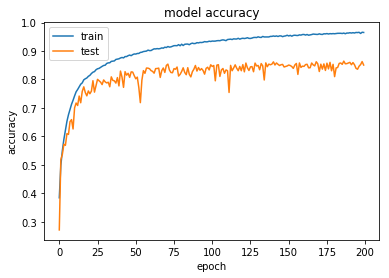

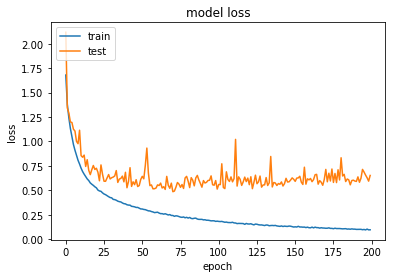

In [182]:
import matplotlib.pyplot as plt

plt.plot(histori.history['acc'])
plt.plot(histori.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(histori.history['loss'])
plt.plot(histori.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()